## Load replay buffer

In [1]:
import pickle
import torch
from src.utils import load_replay_buffer
from src.learning.symmetry_discovery.differential.kernel_approx import KernelFrameEstimator

TASK_NAME="sac_circle_rotation_task_0"
N_SAMPLES:int=50_000
KERNEL_DIM=1
EPSILON_BALL = 0.005
EPSILON_LEVEL_SET = 0.0025

LEARN_KERNEL_BASES: bool=True
replay_buffer_name:str=TASK_NAME+"_replay_buffer.pkl"
kernel_bases_name:str=TASK_NAME+"_kernel_bases.pkl"

replay_buffer_task_1= load_replay_buffer(replay_buffer_name, N_steps=N_SAMPLES)

next_ps=replay_buffer_task_1["next_observations"]
ns=replay_buffer_task_1["rewards"]


with open(kernel_bases_name, 'rb') as f:
    kernel_samples = pickle.load(f)

2025-07-01 12:14:03.442195: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:68: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")


In [6]:
frameestimator= KernelFrameEstimator(ps=next_ps, kernel_dim=KERNEL_DIM)
frameestimator.set_frame(frame=kernel_samples)
p_query=torch.randn((2))
frameestimator.evaluate(p_query, k=10, bandwidth=0.5)

tensor([[-0.9999],
        [-0.0166]])

## Extrapolate via KDE

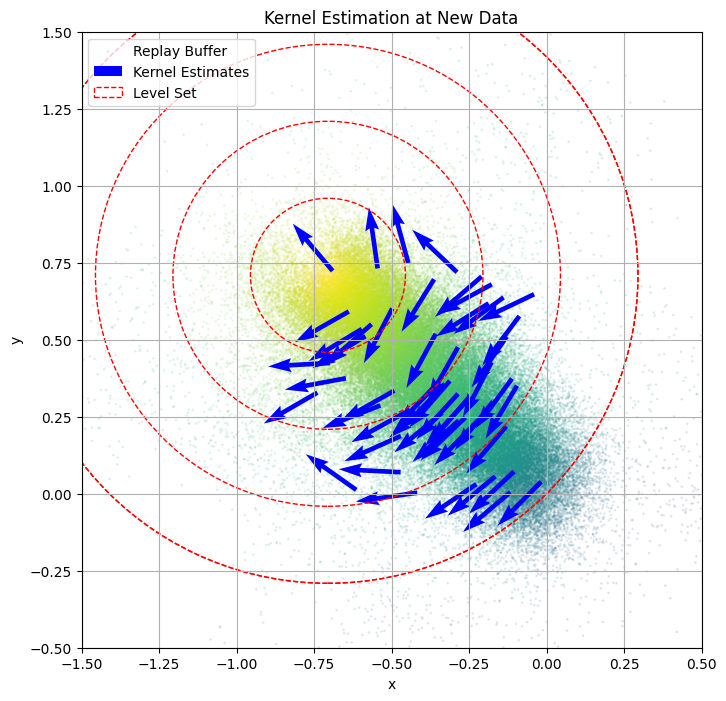

In [3]:
import numpy as np

import matplotlib.pyplot as plt

# Sample 50 points uniformly in the 2D plane

num_points = 50
x = np.random.uniform(-0.75, 0, num_points)
y = np.random.uniform(0, 0.75, num_points)
points = np.stack([x, y], axis=1)

# Feed points into smooth_subspace and collect vectors
vectors = []
for point in points:
    p_query = torch.tensor(point, dtype=torch.float32)
    V_smooth = frameestimator.evaluate(p_query, k=10, bandwidth=0.5)
    vectors.append(V_smooth.numpy())  # Extract the first row of the smoothed subspace

vectors = np.array(vectors)
# Add circles around the specified goal point

# Plot points and vectors using quiver
plt.figure(figsize=(8, 8))
plt.scatter(next_ps[:, 0], next_ps[:, 1], c=ns, s=1, alpha=0.1, label="Replay Buffer")
plt.quiver(points[:, 0], points[:, 1], vectors[:, 0], vectors[:, 1], angles='xy', scale_units='xy', scale=5, color='blue', label="Kernel Estimates")

goal = np.array([-0.70506063, 0.70914702])
circle_radii = [0.25, 0.5, 0.75, 1]
for radius in circle_radii:
    circle = plt.Circle(goal, radius, color='red', fill=False, linestyle='--')
    plt.gca().add_artist(circle)
circle = plt.Circle(goal, radius, color='red', fill=False, linestyle='--', label="Level Set")
plt.gca().add_artist(circle)

plt.xlim(-1.5, 0.5)
plt.ylim(-0.5, 1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Kernel Estimation at New Data')
plt.grid()
plt.show()

## Matrix logarithm

In [7]:
import scipy.linalg
import torch

def adjoint(A, E, f):
    A_H = A.mH.to(E.dtype)
    n = A.size(0)
    M = torch.zeros(2*n, 2*n, dtype=E.dtype, device=E.device)
    M[:n, :n] = A_H
    M[n:, n:] = A_H
    M[:n, n:] = E
    return f(M)[:n, n:].to(A.dtype)

def logm_scipy(A):
    return torch.from_numpy(scipy.linalg.logm(A.cpu(), disp=False)[0]).to(A.device)

class Logm(torch.autograd.Function):
    @staticmethod
    def forward(ctx, A):
        assert A.ndim == 2 and A.size(0) == A.size(1)  # Square matrix
        assert A.dtype in (torch.float32, torch.float64, torch.complex64, torch.complex128)
        ctx.save_for_backward(A)
        return logm_scipy(A)

    @staticmethod
    def backward(ctx, G):
        A, = ctx.saved_tensors
        return adjoint(A, G, logm_scipy)

logm = Logm.apply

A = torch.rand(3, 3, dtype=torch.float64, requires_grad=True)
torch.autograd.gradcheck(logm, A)
A = torch.rand(3, 3, dtype=torch.complex128, requires_grad=True)
torch.autograd.gradcheck(logm, A)

True